In [1]:
# the necessary incantation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import cifar10
from keras.models import Model
from keras.layers import (Conv2D, MaxPooling2D, SeparableConv2D, Activation,
                          Dropout, Flatten, Input, Concatenate, GlobalAveragePooling2D, Lambda)
from tensorflow.nn import space_to_depth
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.utils import np_utils
from keras.optimizers import SGD

Using TensorFlow backend.


In [13]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/EVA")

In [2]:
# load the cifar10 dataset using keras API
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_train, img_channels, img_height, img_width = x_train.shape
num_test, _, _, _ = x_test.shape
num_classes = len(np.unique(y_train))

170500096/170498071 [==============================] - 2s 0us/step


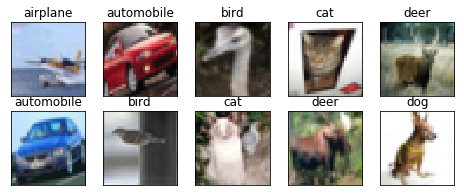

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

'''
We should always look at some sample of images before constructing any model
as it helps in determinig the size of final receptive field, placement of first
pool layer in the network.
'''
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8,3))

for i in range(2):
  for j in range(5):
    idx = np.where(y_train==(i+j))[0]
    features_idx = x_train[idx, :]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax[i, j].imshow(im)
    ax[i, j].set_title(class_names[i+j])
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].set_xticklabels([])
    ax[i, j].set_yticklabels([])
plt.show()

In [0]:
# plot to view how the accuracy and loss varied with epoch

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# convert class labels to binary class labels
y_train_labels = np_utils.to_categorical(y_train, num_classes)
y_test_labels = np_utils.to_categorical(y_test, num_classes)

In [0]:
# normalising the training data
x_train = x_train.astype('float32')
x_train_mean = np.mean(x_train, axis=(0,1,2))
x_train_std = np.std(x_train, axis=(0,1,2))
x_train_norm = (x_train-x_train_mean)/x_train_std
x_test_norm = (x_test-x_train_mean)/x_train_std

In [0]:
# combining the conv-relu-bn layers so that we save on typing them every time
def conv(features_in, filters, kernel=(3,3), padding='same', sep=False):
  if sep == False:
    convolution = Conv2D(filters=filters, kernel_size=kernel, padding=padding)(features_in)
    relu = Activation('relu')(convolution)
    features_out = BatchNormalization()(relu)

  else:
    convolution = SeparableConv2D(filters=filters, kernel_size=kernel, padding=padding)(features_in)
    relu = Activation('relu')(convolution)
    features_out = BatchNormalization()(relu)
    
  return features_out

In [17]:
model_input = Input(shape=(32,32,3))

l1 = conv(model_input, 32, (5,5), padding='valid', sep=True) # in: 32x32x3, out: 28x28x32

l2 = conv(l1, 64, (5,5), padding='same') # in: 28x28x32, out: 28x28x64

l3 = conv(l2, 128, (5,5), padding='same') # in: 28x28x64, out: 28x28x128

l4_in = Concatenate(axis=-1)([l1, l3])
l4 = conv(l4_in, 128, (5,5), padding='same', sep='True') # in: 28x28x160, out: 28x28x128

l5_in = Concatenate(axis=-1)([l1, l4])
drop5 = Dropout(0.1)(l5_in)
l5 = MaxPooling2D(pool_size=(2,2))(drop5) # in: 28x28x128 out: 14x14x128
l5 = conv(l5, 32, (1,1), padding='same') # in: 14x14x128, out: 14x14x32

l6 = conv(l5, 64, (3,3), padding='same', sep=True) # in: 14x14x32, out: 14x14x64

l1_spd = Lambda(space_to_depth, arguments={'block_size': 2})(l1) 
l4_spd = Lambda(space_to_depth, arguments={'block_size': 2})(l4)
l7_in = Concatenate(axis=-1)([l1_spd, l4_spd, l6])

# using 1x1 to reduce the number of channels as with current channel size 
# number of params just explode
l7_pw = conv(l7_in, 32, (1, 1)) # in: 14x14x704, out: 14x14x32 
l7 = conv(l7_pw, 128, (5,5), padding='same', sep=False) # in: 14x14x32, out: 14x14x128

l3_spd = Lambda(space_to_depth, arguments={'block_size': 2})(l3)
l8_in = Concatenate(axis=-1)([l7, l6, l4_spd, l3_spd])
l8_pw = conv(l8_in, 64, (1, 1)) # in: 14x14x1216, out: 14x14x64
l8 = conv(l8_pw, 128, (3,3), padding='same', sep=True) # in: 14x14x64, out: 14x14x128

l9_in = Concatenate(axis=-1)([l8, l7, l6, l4_spd, l3_spd, l1_spd])
l9_pw = conv(l9_in, 64, (1, 1)) # in: 14x14x1472, out: 14x14x64
l9 = conv(l9_pw, 128, (5, 5), padding='same', sep=True) # in: 14x14x64, out: 14x14x128
drop9 = Dropout(0.1)(l9)

l10 = MaxPooling2D(pool_size=(2, 2))(drop9) # in: 14x14x128, out: 7x7x128
l10 = conv(l10, 32, (1, 1)) # in: 7x7x128, out: 7x7x32

# Lambda function is required as each of the input must be keras layer.
# If you simply use the space_to_depth function without using Lambda, then, 
# you will get an error. By using lambda l6_spd and all become layers. 
l6_spd = Lambda(space_to_depth, arguments={'block_size': 2})(l6) 
l7_spd = Lambda(space_to_depth, arguments={'block_size': 2})(l7)
l8_spd = Lambda(space_to_depth, arguments={'block_size': 2})(l8)
l9_spd = Lambda(space_to_depth, arguments={'block_size': 2})(l9)

l1_spd = Lambda(space_to_depth, arguments={'block_size': 4})(l1)
l2_spd = Lambda(space_to_depth, arguments={'block_size': 4})(l2)
l3_spd = Lambda(space_to_depth, arguments={'block_size': 4})(l3)
l4_spd = Lambda(space_to_depth, arguments={'block_size': 4})(l4)

l11_in = Concatenate(axis=-1)([l10, l7_spd])
l11_pw = conv(l11_in, 32, (1,1)) # in: 7x7x544, out: 7x7x32
l11 = conv(l11_pw, 64, (5,5), padding='same', sep=False) # in: 7x7x32, out: 7x7x64

l12_in = Concatenate(axis=-1)([l11, l8_spd, l2_spd, l1_spd])
l12_pw = conv(l12_in, 64, (1,1)) # in: 7x7x960, out: 7x7x64
l12 = conv(l12_pw, 128, (5,5), padding='same', sep=True) # in: 7x7x64, out: 7x7x128

l13_in = Concatenate(axis=-1)([l12, l11, l6_spd, l3_spd, l2_spd])
l13_pw = conv(l13_in, 64, (1,1)) # in: 7x7x1216, out: 7x7x64
l13 = conv(l13_pw, 128, (3,3), padding='same', sep=False) # in: 7x7x64, out: 7x7x128

l14_in = Concatenate(axis=-1)([l13, l12, l8_spd, l6_spd, l4_spd, l3_spd, l1_spd])
l14_pw = conv(l14_in, 64, (1,1)) # in: 7x7x2176, out: 7x7x64
l14 = conv(l14_pw, 128, (5,5), padding='same', sep=True) # in: 7x7x64, out: 7x7x128

soft_in = Concatenate(axis=-1)([l14, l12, l8_spd, l4_spd])
soft_pw = Conv2D(10, (1,1))(soft_in) # in: 7x7x1280, out: 7x7x10
soft_gap = GlobalAveragePooling2D()(soft_pw) # in: 7x7x10 out: 1x1x10
# flatten = Flatten()(soft_gap)
output = Activation('softmax')(soft_gap)

model = Model(inputs=model_input, outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_15 (SeparableC (None, 28, 28, 32)   203         input_3[0][0]                    
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 28, 28, 32)   0           separable_conv2d_15[0][0]        
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 28, 28, 32)   128         activation_45[0][0]              
____________________________________________________________________________________________

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=['accuracy'])

# scheduler to decrease the learning rate in the later epochs so that 
# objective function reaches the neighbourhood of its minima
def schedule(epoch):
  if epoch < 25:
    return 0.01
  elif epoch < 50:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (50 - epoch))

lr_scheduler = LearningRateScheduler(schedule)

checkpoint = ModelCheckpoint(filepath="model.{epoch:02d}-{val_acc:.2f}.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True, 
                             period=10)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390.625, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=100)`


Epoch 1/100
391/390 [==============================] - 136s 347ms/step - loss: 1.7393 - acc: 0.3643 - val_loss: 1.5190 - val_acc: 0.4590
Epoch 2/100
391/390 [==============================] - 130s 332ms/step - loss: 1.5124 - acc: 0.4577 - val_loss: 1.4235 - val_acc: 0.5099
Epoch 3/100
391/390 [==============================] - 130s 333ms/step - loss: 1.4055 - acc: 0.5011 - val_loss: 1.4109 - val_acc: 0.5177
Epoch 4/100
391/390 [==============================] - 130s 333ms/step - loss: 1.3221 - acc: 0.5317 - val_loss: 1.2318 - val_acc: 0.5677
Epoch 5/100
391/390 [==============================] - 130s 332ms/step - loss: 1.2564 - acc: 0.5555 - val_loss: 1.1774 - val_acc: 0.5869
Epoch 6/100
391/390 [==============================] - 130s 333ms/step - loss: 1.2011 - acc: 0.5766 - val_loss: 1.1284 - val_acc: 0.6077
Epoch 7/100
391/390 [==============================] - 130s 333ms/step - loss: 1.1556 - acc: 0.5950 - val_loss: 1.1240 - val_acc: 0.6125
Epoch 8/100
391/390 [====================

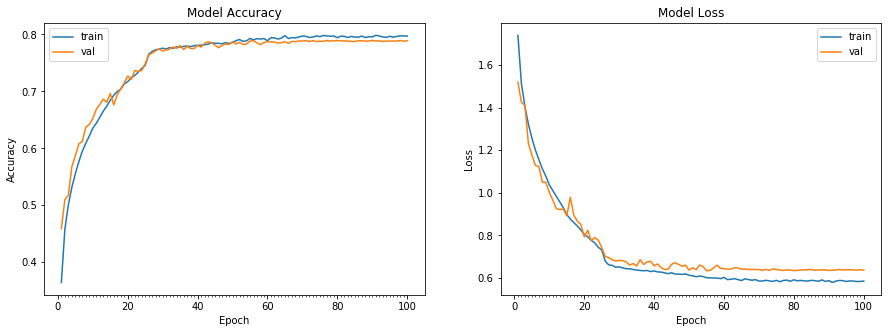

In [21]:
from keras.preprocessing.image import ImageDataGenerator
import time
# Using data augmentation techniques to generalise the model further 
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

datagen.fit(x_train_norm)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(x_train_norm, y_train_labels, batch_size = 128),
                                 steps_per_epoch = x_train_norm.shape[0]/128, nb_epoch = 100, 
                                 validation_data = (x_test_norm, y_test_labels), 
                                 verbose=1, callbacks=[lr_scheduler,checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

In [23]:
# accuracy at the final epoch
model.evaluate(x_test_norm, y_test_labels, batch_size=128)


10000/10000 [==============================] - 7s 698us/step


[0.6370144384384155, 0.7889]